In [280]:
# -*- coding:utf-8 -*-
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim
import torchvision.transforms as transforms
import torch.nn.functional as F
from tqdm import tqdm
from sklearn.model_selection import train_test_split

In [281]:
def train(train_loader, net, optimizer, loss,device='cpu'):
    # set model to train mode
    net.train()
    corrects = 0
    for inputs, labels in tqdm(train_loader):

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear the gradients
        optimizer.zero_grad()
        inputs =inputs.float()
        outputs = net(inputs)  # inputs格式要为float
        l = loss(outputs, labels)
        l.backward()
        optimizer.step()
        
        preds = outputs.argmax(1).detach()
        y=labels.argmax(1)
        
        corrects += (preds == y).sum()
    # return torch.true_divide(corrects, len(train_loader.dataset)).item()
    return corrects/len(train_loader.dataset),l.item()



In [282]:
def test(test_loader, loss,net,device='cpu'):

    # set model to eval mode
    net.eval()
    corrects = 0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            inputs =inputs.float()
            outputs = net(inputs)
            preds = outputs.argmax(1).detach()
            y=labels.argmax(1)
            l = loss(outputs, labels)
            corrects += (preds == y).sum()
            
    return corrects/len(test_loader.dataset),l.item()

In [283]:
class MYCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(MYCNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc = nn.Linear(7*7*32, num_classes)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        return out

In [284]:
class my_dataset(Dataset):
    def __init__(self,x,y,transforms=None):
        self.x = x
        final=np.zeros((y.shape[0],10))
        for i in range(len(y)):
            final[i,y[i]]=1
        self.y=final
        
        print(x.shape,self.y.shape)
        self.transforms=transforms
        
    def __getitem__(self, index):
        if self.transforms!=None:
            return self.transforms(self.x[index].reshape((28,28))),self.y[index,:]
        else:
            return self.x[index,:].reshape((28,28)), self.y[index]
        
    def __len__(self):
        return len(self.x)

In [285]:
model=MYCNN()
net = model.cuda()
device="cuda"
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
loss = nn.CrossEntropyLoss()
batch_size=128

In [286]:
train_transforms = transforms.Compose([

    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[ 0.5])

])

X = np.load('data//x.npy',allow_pickle=1)
Y=np.load('data//y.npy',allow_pickle=1)


# 将数据集分为训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=0.2)
train_data=my_dataset(X_train,y_train,transforms=train_transforms)
test_data=my_dataset(X_test,y_test,transforms=train_transforms)
train_loader = DataLoader(train_data,  shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

(56000, 784) (56000, 10)
(14000, 784) (14000, 10)


In [287]:
train_acc = []
test_acc = []
train_loss = []
test_loss = []
epoch = 5
max_acc = 0
for i in (range(epoch)):
    temp_acc, temp_loss = train(train_loader, net, optimizer, loss, device)
    train_acc.append(temp_acc)
    train_loss.append(temp_loss)
    
    temp_acc, temp_loss = test(test_loader, loss, net, device)
    test_acc.append(temp_acc)
    test_loss.append(temp_loss)
    if temp_acc >= max_acc:
        max_acc = temp_acc
        torch.save(model.state_dict(),  'best.pth')
    print("Epoch: %d  Train Loss: %.3f, Acc: %.3f" %
          (i+1, train_loss[i], train_acc[i]))
    print("Epoch: %d  Test Loss: %.3f, Acc: %.3f\n" %
          (i+1, test_loss[i], test_acc[i]))


100%|██████████| 110/110 [00:01<00:00, 104.49it/s]


Epoch: 1  Train Loss: 0.151, Acc: 0.954
Epoch: 1  Test Loss: 0.104, Acc: 0.980



100%|██████████| 110/110 [00:01<00:00, 108.87it/s]


Epoch: 2  Train Loss: 0.015, Acc: 0.984
Epoch: 2  Test Loss: 0.187, Acc: 0.982



100%|██████████| 110/110 [00:01<00:00, 108.47it/s]


Epoch: 3  Train Loss: 0.040, Acc: 0.988
Epoch: 3  Test Loss: 0.056, Acc: 0.983



100%|██████████| 110/110 [00:01<00:00, 108.36it/s]


Epoch: 4  Train Loss: 0.006, Acc: 0.990
Epoch: 4  Test Loss: 0.044, Acc: 0.985



100%|██████████| 110/110 [00:01<00:00, 107.16it/s]

Epoch: 5  Train Loss: 0.017, Acc: 0.992
Epoch: 5  Test Loss: 0.059, Acc: 0.990



In [288]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# -- 混淆矩阵 --
# t为结果向量(n,1)，y为标签向量(n,1)，classes为标签列表(n,)
# 其中默认标签y[i][0]表示classes[y[i][0]]类，比如classes=['猫','狗','鸭子','猪']，若y[i][0]为0则表示为猫
def confusion_matrix_plt(t, y, classes):
    # 构建混淆矩阵
    confusion_matrix = np.zeros((len(classes), len(classes)), dtype='int')
    for i in range(t.shape[0]):
        confusion_matrix[y[i][0]][t[i][0]] += 1
    # print(confusion_matrix)

    # 可视化
    proportion = []
    for i in confusion_matrix:
        for j in i:
            temp = j
            proportion.append(temp)

    proportion = np.array(proportion).reshape(len(classes), len(classes))  # reshape(列的长度，行的长度)

    config = {
        "font.family": 'Times New Roman',  # 设置字体类型
    }
    rcParams.update(config)
    plt.imshow(proportion, interpolation='nearest', cmap=plt.cm.Blues)  # 按照像素显示出矩阵
    # (改变颜色：'Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds','YlOrBr', 'YlOrRd',
    # 'OrRd', 'PuRd', 'RdPu', 'BuPu','GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn')
    plt.title('confusion_matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=12)
    plt.yticks(tick_marks, classes, fontsize=12)

    thresh = confusion_matrix.max() / 2.

    iters = np.reshape([[[i, j] for j in range(len(classes))] for i in range(len(classes))], (confusion_matrix.size, 2))
    for i, j in iters:
        if (i == j):
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center', fontsize=12, color='white',
                     weight=5)  # 显示对应的数字

        else:
            plt.text(j, i - 0.12, format(confusion_matrix[i, j]), va='center', ha='center', fontsize=12)  # 显示对应的数字

    plt.ylabel('True label', fontsize=16)
    plt.xlabel('Predict label', fontsize=16)
    plt.tight_layout()
    plt.show()

In [325]:
class1=np.argmax(test_loader.dataset.y,axis=1)
device='cpu'
all_outputs = np.empty((0, 10))
net.to(device)
for inputs, targets in test_loader:
    inputs = inputs.to(device).float()
    targets = targets.to(device)
    outputs = net.forward(inputs)
    outputs = outputs.detach()
    # 将outputs转换为numpy数组
    outputs = outputs.numpy()
    all_outputs = np.concatenate((all_outputs, outputs), axis=0)
    # print(all_outputs.shape)

y_pre=np.array(all_outputs)

class2=np.argmax(y_pre,axis=1)
class2.shape

(14000,)

In [326]:
class1=class1.reshape(class1.shape[0],-1)
class2=class2.reshape(class2.shape[0],-1)
class1.shape,class2.shape

((14000, 1), (14000, 1))

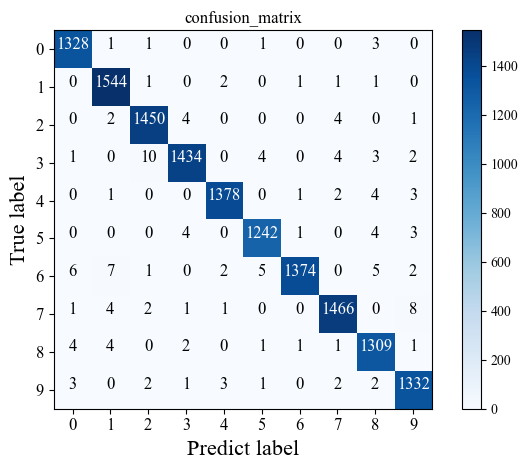

In [327]:
confusion_matrix_plt(class1,class2,range(10))